In [1]:
import numpy as np
#  %    matplotlib notebook
import matplotlib.pyplot as plt
import multiprocessing
import tifffile
import sys, time, os, csv
import cProfile, pstats
from jutils import tqdm_alias as tqdm

import psfmatrix, lfimage
import projector, lfdeconv
import special_fftconvolve as special
import jutils as util
import py_light_field as plf

Unable to import cupy - no GPU support will be available
Unable to import cupy - no GPU support will be available
Unable to import cupy - no GPU support will be available


In [13]:
projectorClass = projector.Projector_allC
maxiter = 8
inputImage = lfimage.LoadLightFieldTiff('/Users/jonny/Movies/Nils files/Rectified/Left/Cam_Left_40_X1_N19.tif')
hMatrix = psfmatrix.LoadMatrix('PSFmatrix/reducedPSFMatrix_M22.2NA0.5MLPitch125fml3125from-156to156zspacing4Nnum19lambda520n1.33.mat')

In [12]:
hMatrixSmall = psfmatrix.LoadMatrix('PSFmatrix/normPSFMatrix_M22.2NA0.5MLPitch125fml3125from-12to0zspacing4Nnum19lambda520n1.33.mat')
hMatrixSmall1 = psfmatrix.LoadMatrix('PSFmatrix/normPSFMatrix_M22.2NA0.5MLPitch125fml3125from-12to-8zspacing4Nnum19lambda520n1.33.mat')
hMatrixSmall2 = psfmatrix.LoadMatrix('PSFmatrix/normPSFMatrix_M22.2NA0.5MLPitch125fml3125from-4to0zspacing4Nnum19lambda520n1.33.mat')

Failed to load array shapes. There are probably no memmap files either.
We will now try to generate them from scratch from the .mat file, which will take a little while


OSError: Unable to open file (Unable to open file: name = 'psfmatrix/normpsfmatrix_m22.2na0.5mlpitch125fml3125from-12to0zspacing4nnum19lambda520n1.33.mat', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

### Stability investigations
Does the deconvolution converge to a stable image (importantly: with a stable absolute amplitude) as we run increasing numbers of iterations? The maximum values do seem to rise a little, but the sum does at least seem to remain approximately the same. **Conclusion**: I am reassured that the sum remains approximately the same. The maximum is rising because energy is being transferred into different artefacts, but I think it's maybe unreasonable to expect things to be stable and sane here, since I am reconstructing only two planes of what is in reality a much larger volume.

Can we do an initial reconstruction, subtract the contribution from most of the planes to the camera image, and then perform subsequent reconstructions on just a few planes of interest in the dataset? (This is what I want to do with my flow analysis, where I don't want to be having to reconstruct the whole volume during my iterative optimization, when I am only interested in the artefact-corrupted planes). **Conclusion**: yes, that does seem to work - I get pretty much the same reconstruction as in the original, full reconstruction. I suspect any discrepancies may be partly due to the differing rate of convergence of the full problem and the reduced-planes problem.

In [ ]:
# Generate a synthetic four-plane image
obj = tifffile.imread('Data/03_Reconstructed/exampleData/definitive_worm_crop_X15_backproject.tif')
obj = obj[7:11,np.newaxis].astype(np.float32)
im = lfdeconv.ForwardProjectACC(hMatrixSmall, obj, progress=tqdm, projector=projectorClass())

In [ ]:
# Deconvolve the full four planes
Htf = lfdeconv.BackwardProjectACC(hMatrixSmall, im, progress=tqdm, projector=projectorClass())
obj8 = lfdeconv.DeconvRL(hMatrixSmall, Htf, 8, Htf.copy(), logPrint=False)

In [ ]:
# Sanity check that intensities remain approx the same as we iterate the deconvolution.
if True:
    obj10 = lfdeconv.DeconvRL(hMatrixSmall, Htf, 2, obj8, logPrint=False)
    obj20 = lfdeconv.DeconvRL(hMatrixSmall, Htf, 10, obj10, logPrint=False)
    
    print(np.max(obj8), np.sum(obj8))
    print(np.max(obj10), np.sum(obj10))
    print(np.max(obj20), np.sum(obj20))

    plt.figure()
    plt.imshow(obj8[0,0])
    plt.show()
    plt.figure()
    plt.imshow(obj10[0,0])
    plt.show()    
    plt.figure()
    plt.imshow(obj20[0,0])
    plt.show()        

In [ ]:
# Forward-project just the first, and second, halves of that reconstructed object
imFirstHalf = lfdeconv.ForwardProjectACC(hMatrixSmall1, obj8[0:2], progress=tqdm, projector=projectorClass())
imSecondHalf = lfdeconv.ForwardProjectACC(hMatrixSmall2, obj8[2:4], progress=tqdm, projector=projectorClass())

In [ ]:
# Subtract the forward-projection of the first two planes from our original camera image,
# and try reconstructing the second two planes in isolation.
imPartial = im - imFirstHalf
obj8SecondHalf = lfdeconv.DeconvRL(hMatrixSmall2, None, 8, None, im=imPartial, logPrint=False)

In [ ]:
# Compare the reconstructions
plt.imshow(obj8[2,0]); plt.colorbar(); plt.show()
plt.imshow(obj8SecondHalf[0,0]); plt.colorbar(); plt.show()
plt.imshow(obj8[3,0]); plt.colorbar(); plt.show()
plt.imshow(obj8SecondHalf[1,0]); plt.colorbar(); plt.show()

### Does normalisation affect deconvolution appearance?
Normalisation affects the absolute intensity values, but does it appear to make any difference to the actual qualitative appearance of the image?

In [ ]:
hMatrixNorm = psfmatrix.LoadMatrix('PSFmatrix/normPSFmatrix_M40NA0.95MLPitch150fml3000from-26to0zspacing2Nnum15lambda520n1.mat')
objUnnorm = tifffile.imread('Data/03_Reconstructed/exampleData/definitive_worm_crop_X15_backproject.tif')
im = tifffile.imread('Data/02_Rectified/exampleData/20131219WORM2_small_full_neg_X1_N15_cropped_uncompressed.tif')
objNorm = lfdeconv.DeconvRL(hMatrixNorm, None, 8, None, im=im, logPrint=False)

In [ ]:
tifffile.imwrite('unnorm.tif', objUnnorm)
tifffile.imwrite('norm.tif', objNorm)

### Do the actual deconvolution of some of Nils's data

Note that I have fixed the max bug, and also flux-normalised H.

In [15]:
hMatrix = psfmatrix.LoadMatrix('PSFmatrix/fdnormPSFMatrix_M22.2NA0.5MLPitch125fml3125from-156to156zspacing4Nnum19lambda520n1.33.mat')
inputImage = []
for i in range(40, 48):
    im = lfimage.LoadLightFieldTiff('/Users/jonny/Movies/Nils files/Rectified/Left/Cam_Left_%d_X%d_N19.tif'%(i, i-39))
    inputImage.append(im)
inputImage = np.array(inputImage)

In [23]:
Htf = lfdeconv.BackwardProjectACC(hMatrix, inputImage, planes=None, progress=tqdm, logPrint=False, projector=projectorClass())
deconvolvedResult = lfdeconv.DeconvRL(hMatrix, Htf, maxIter=maxiter, Xguess=Htf.copy(), logPrint=False, projectorClass=projectorClass)
tifffile.imsave('Data/03_Reconstructed/Left/Cam_Left_40_X1_N19_fdnorm.tif', deconvolvedResult[:,0].transpose((0,2,1)))
# Deconvolution elapsed wallclock time 4622.118029, rusage 13171.732090

iter 1/8 took 762.3 secs
iter 2/8 took 728.4 secs
iter 3/8 took 731.2 secs
iter 4/8 took 744.7 secs
iter 5/8 took 773.2 secs
iter 6/8 took 746.7 secs
iter 7/8 took 752.0 secs
iter 8/8 took 738.3 secs

Deconvolution elapsed wallclock time 5976.710562, rusage 29942.331973


In [ ]:
#tifffile.imsave('Data/03_Reconstructed/Left/Cam_Left_40_X1_N19.tif', deconvolvedResult.transpose((0,2,1)))
if False:
    for i in range(deconvolvedResult.shape[1]):
        tifffile.imsave('Data/03_Reconstructed/Left/Cam_Left_%d_X%d_N19.tif'%(40+i, 1+i), deconvolvedResult.transpose((0,2,1)))

### Compare the deconvolutions as obtained from various different PSFs
It's clear that the max bug does increase the artefacts in the native focal plane, although it's not catastrophic. It's hard to quantify how much difference the normalisation makes, but it is not a huge visual impact, and the relative differences seem to be on the 10% level.

In [3]:
theirs = tifffile.imread('/Users/jonny/Movies/Nils files/Single-view-reconstructions/Cam_Left_40_uncompressed.tif')
mineNorm = tifffile.imread('Data/03_Reconstructed/Left/Cam_Left_40_X1_N19.tif')
mineUnnorm = tifffile.imread('Data/03_Reconstructed/Left/Cam_Left_40_X1_N19_unnorm.tif')
mineFDnorm = tifffile.imread('Data/03_Reconstructed/Left/Cam_Left_40_X1_N19_fdnorm.tif')

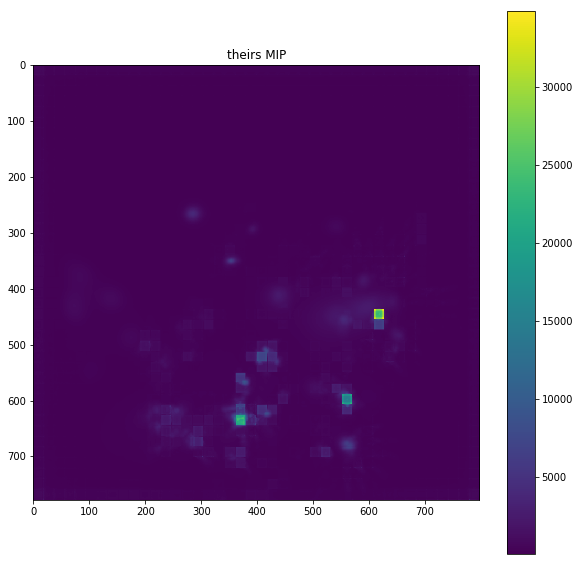

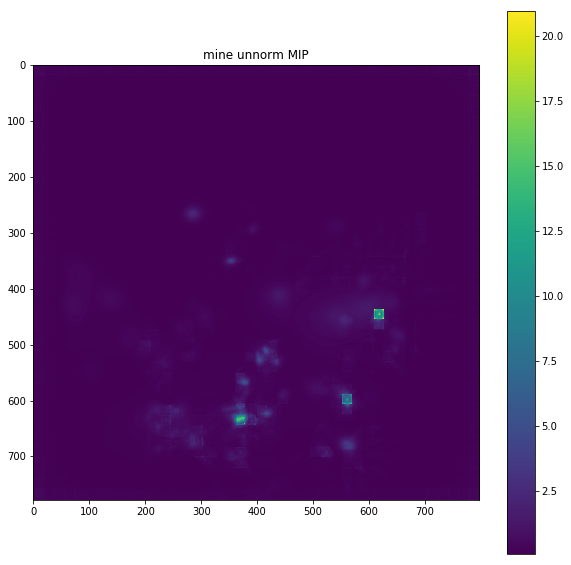

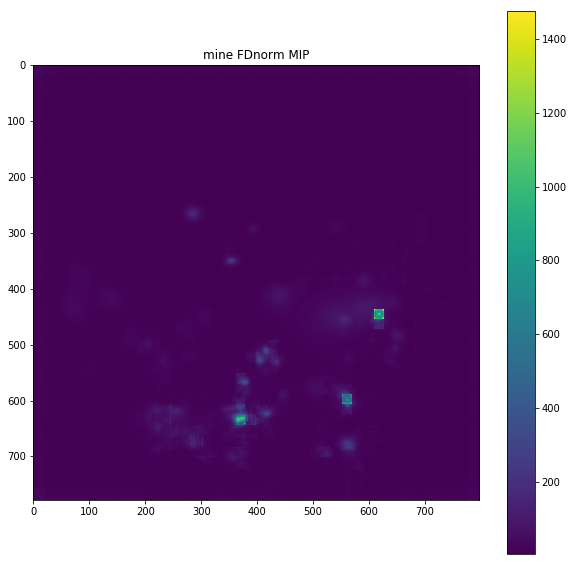

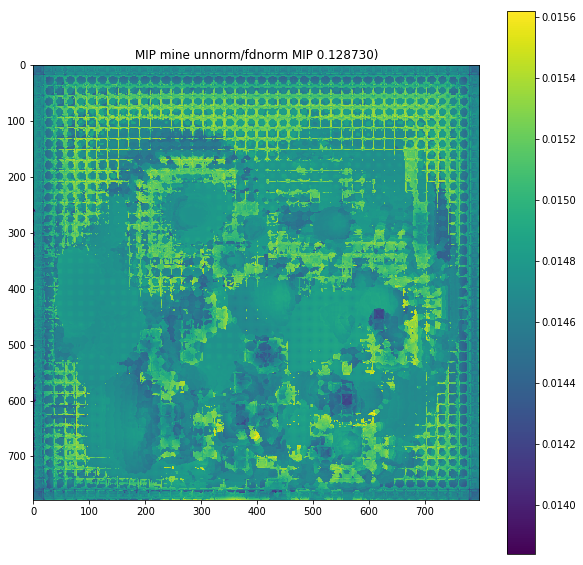

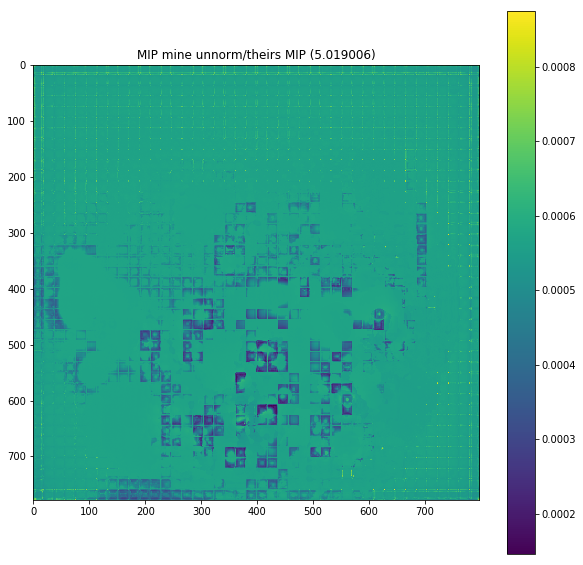

In [22]:
for cc in [20, 38, 39, 40, 55]:
    plt.figure(figsize=(10,10)); plt.title('theirs %d'%cc)
    plt.imshow(theirs[cc])
    plt.colorbar(); plt.show()
    if False:
        plt.figure(figsize=(10,10)); plt.title('mineNorm %d'%cc)
        plt.imshow(mineNorm[cc])
        plt.colorbar(); plt.show()
        plt.figure(figsize=(10,10)); plt.title('mineUnnorm %d'%cc)
        plt.imshow(mineUnnorm[cc])
        plt.colorbar(); plt.show()
    plt.figure(figsize=(10,10)); plt.title('mineFDnorm %d'%cc)
    plt.imshow(mineFDnorm[cc])
    plt.colorbar(); plt.show()
    frac = mineUnnorm[cc]/mineFDnorm[cc]
    plt.figure(figsize=(10,10)); plt.title('mine unnorm/fdnorm %d (%f)'%(cc, (np.max(frac)-np.min(frac))/np.min(frac)))
    plt.imshow(frac)
    plt.colorbar(); plt.show()
    frac = mineUnnorm[cc]/theirs[cc]
    plt.figure(figsize=(10,10)); plt.title('mine unnorm/theirs %d (%f)'%(cc, (np.max(frac)-np.min(frac))/np.min(frac)))
    plt.imshow(frac)
    plt.colorbar(); plt.show()    
    
plt.figure(figsize=(10,10)); plt.title('theirs MIP')
plt.imshow(np.max(theirs, axis=0))
plt.colorbar(); plt.show()
plt.figure(figsize=(10,10)); plt.title('mine unnorm MIP')
plt.imshow(np.max(mineUnnorm, axis=0))
plt.colorbar(); plt.show()
plt.figure(figsize=(10,10)); plt.title('mine FDnorm MIP')
plt.imshow(np.max(mineFDnorm, axis=0))
plt.colorbar(); plt.show()

frac = np.max(mineUnnorm,axis=0)/np.max(mineFDnorm,axis=0)
plt.figure(figsize=(10,10)); plt.title('MIP mine unnorm/fdnorm MIP %f)'%((np.max(frac)-np.min(frac))/np.min(frac)))
plt.imshow(frac)
plt.colorbar(); plt.show()
frac = np.max(mineUnnorm,axis=0)/np.max(theirs,axis=0)
plt.figure(figsize=(10,10)); plt.title('MIP mine unnorm/theirs MIP (%f)'%((np.max(frac)-np.min(frac))/np.min(frac)))
plt.imshow(frac)
plt.colorbar(); plt.show()    